In [77]:
import pandas as pd  # type: ignore
import matplotlib.pyplot as plt  # type: ignore
import numpy as np  # type: ignore
import tensorflow as tf 

In [2]:
df = pd.read_csv('./../processed_data/filtered_data_with_classes.csv')

In [4]:
from sklearn.preprocessing import LabelEncoder  # type: ignore
from sklearn.model_selection import train_test_split  # type: ignore
from sklearn.metrics import accuracy_score  # type: ignore

In [6]:
# Encoding categorical variables (if 'condition_text' is categorical)
label_encoder = LabelEncoder()
df['condition_text'] = label_encoder.fit_transform(df['condition_text'])

# Separating features and target variable
X = df.drop('condition_text', axis=1)  # Features
y = df['condition_text']  # Target

# Step 2: Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [9]:
from keras.models import Sequential # type: ignore
from keras.layers import Dense, Dropout, Input # type: ignore

In [37]:
model = Sequential([
    Input(shape=(14,)),  #input layer with 14 features
    Dense(16, activation='relu'),
    Dropout(0.5),  # Dropout for regularization
    Dense(32, activation='relu'),  # First hidden layer
    Dropout(0.5), 
    Dense(9, activation='softmax')  # Output layer for 9 classes
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [38]:
# from keras.callbacks import Callback # type: ignore

# class LossHistory(Callback):
#     def on_epoch_end(self, epoch, logs={}):
#         if epoch % 10 == 0:  # Every 10 epochs
#             print(f"Epoch {epoch}: Loss = {logs.get('loss')}")

In [39]:
from keras.callbacks import EarlyStopping # type: ignore

# Define the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)

# Fit the model with the early stopping callback
history = model.fit(X_train, y_train, validation_split=0.2,
                    epochs=150, batch_size=32, verbose=0, callbacks=[early_stopping])

Epoch 117: early stopping
Restoring model weights from the end of the best epoch: 107.


In [40]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

Test Accuracy: 50.00%


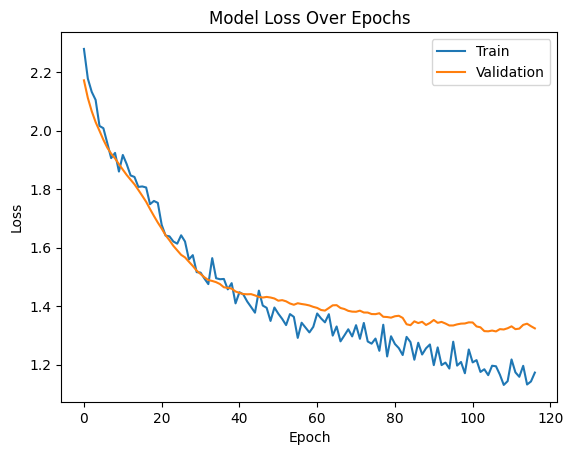

In [41]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [81]:
def create_model(num_classes=14, layers=[64, 32], dropout_rate=0.5):
    model = Sequential()
    # Explicitly define the input layer
    model.add(Input(shape=(X_train.shape[1],)))
    for layer_size in layers:
        model.add(Dense(layer_size, activation='relu'))
        model.add(Dropout(dropout_rate))
    # Adjust the number of units in the output layer to match the number of classes
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [82]:
early_stopping = EarlyStopping(
    monitor='val_loss', patience=20, verbose=1, mode='min', restore_best_weights=True)

In [83]:
def train_and_evaluate_models(model_configs):
    model_histories = {}
    for config in model_configs:
        # Clear the current Keras session
        tf.keras.backend.clear_session()

        # Reset the random seed for reproducibility
        np.random.seed(42)
        tf.random.set_seed(42)

        # Create the model
        model = create_model(layers=config)

        # Setup Early Stopping
        early_stopping = EarlyStopping(
            monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)

        # Train the model
        history = model.fit(X_train, y_train, validation_split=0.2, epochs=100,
                            batch_size=32, verbose=0, callbacks=[early_stopping])

        # Evaluate the model
        test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
        print(f"Model with config {config} - Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
        
        # Store the history of the model
        model_histories[str(config)] = history
    
    return model_histories

In [84]:
model_configs = [
    [8, 16, 32],
    [16, 32],
    [15, 32],
    [12, 32],
    [12, 16, 32],
	[12, 16, 32, 64],
]

In [85]:
histories = train_and_evaluate_models(model_configs)

Restoring model weights from the end of the best epoch: 95.
Model with config [16, 32] - Test Loss: 1.3689, Test Accuracy: 0.4792
Restoring model weights from the end of the best epoch: 100.
Model with config [16, 32] - Test Loss: 1.3702, Test Accuracy: 0.5104
Restoring model weights from the end of the best epoch: 98.
Model with config [15, 32] - Test Loss: 1.4151, Test Accuracy: 0.4792
Restoring model weights from the end of the best epoch: 100.
Model with config [12, 32] - Test Loss: 1.4529, Test Accuracy: 0.4688
Restoring model weights from the end of the best epoch: 100.
Model with config [12, 16] - Test Loss: 1.6287, Test Accuracy: 0.4271


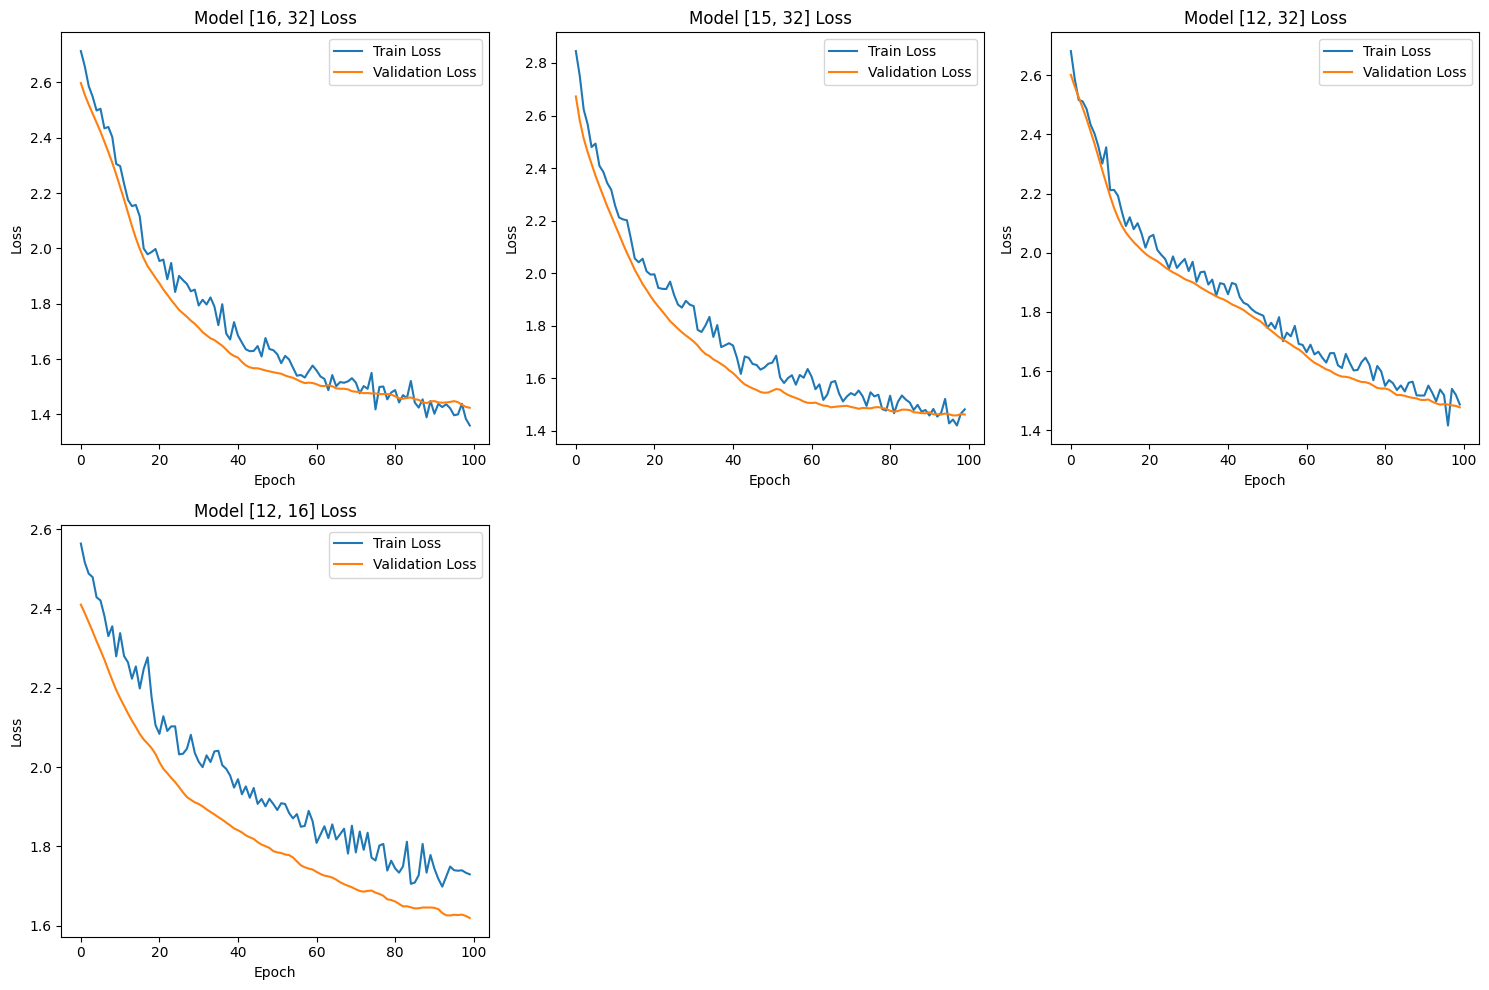

In [87]:
import matplotlib.pyplot as plt


def plot_loss_histories(histories):
    # Determine the total number of plots needed
    num_models = len(histories)
    # Calculate the number of rows needed for 3 plots per row
    # +2 for rounding up to ensure at least one row
    rows = (num_models + 2) // 3

    # Create a figure with subplots arranged in calculated rows and 3 columns
    fig, axs = plt.subplots(rows, 3, figsize=(15, 5 * rows))
    # If there's only one row, axs might not be an array of arrays
    if num_models <= 3:
        # Ensure axs is always a 2D array for consistency
        axs = axs.reshape(1, -1)
    axs = axs.flatten()  # Flatten to make indexing easier

    for i, (config, history) in enumerate(histories.items()):
        # Plot training and validation loss
        axs[i].plot(history.history['loss'], label='Train Loss')
        axs[i].plot(history.history['val_loss'], label='Validation Loss')
        axs[i].set_title(f'Model {config} Loss')
        axs[i].set_ylabel('Loss')
        axs[i].set_xlabel('Epoch')
        axs[i].legend(loc='upper right')

    # Hide any unused subplots
    for j in range(i + 1, len(axs)):
        axs[j].axis('off')

    plt.tight_layout()
    plt.show()

# Assuming 'histories' is your dictionary containing model training histories
plot_loss_histories(histories)